# Part 2 - the MNIST dataset

For ease of use, the MINST handwritten digits dataset comes packaged up with TensorFlow, so let's load it and have a look around.

In [54]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

mnist = tf.keras.datasets.mnist


In [60]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# reshape y to arrays of shape (m,1)
y_train, y_test = y_train.reshape(y_train.shape[0], 1), y_test.reshape(y_test.shape[0], 1)

print ("x_train shape:", x_train.shape)
print ("y_train shape:", y_test.shape)
print ("x_test shape:", x_train.shape)
print ("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (10000, 1)
x_test shape: (60000, 28, 28)
y_test shape: (10000, 1)


Now let's visualise some examples of the training set with their labels

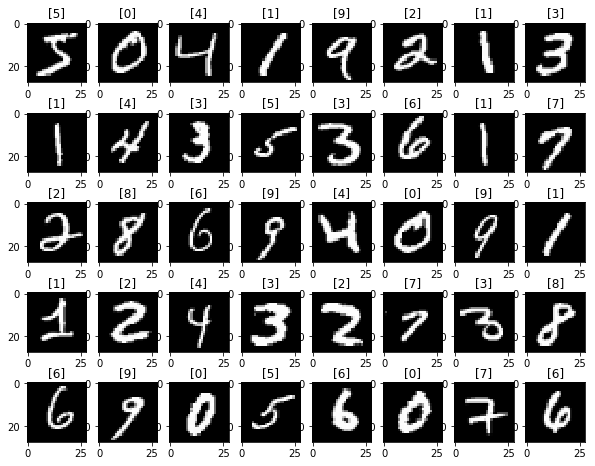

In [56]:
display_examples_n = 40
rows = 5
cols = 8
fig, axarr = plt.subplots(rows, cols)

for r in range (0, rows):
    for c in range (0, cols):
        # axarr[r][c].title.set_text('x_train[' + str((r*cols)+c) +']: ' + str(y_train[(r*cols)+c]))
        axarr[r][c].title.set_text(str(y_train[(r*cols)+c]))
        axarr[r][c].imshow(x_train[(r*cols)+c])

Once again, let's look at the number of items in each class:

In [61]:
np.unique (y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

It would probably be better if the training set had equal numbers of items in each class, and we wrote code that does this in carving up the set into a train and dev set. No need to split off a test set, as we already have one.

In [63]:
np.unique (y_test, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

In [92]:
def get_train_dev_sets (X, Y, train_set_proportion = 0.9):
    """
    Takes set of features (X) as (n,m) matrix and labels (Y) as (1,m) matrix and splits them into train and dev 
    sets only, of specified proportions. It's assumed that a test set isn't needed.
    Train set will have same number of examples of each class
    
    returns: train_set_X, train_set_Y, dev_set_X, dev_set_Y
    """
    
    size_classes = np.unique(Y, return_counts = True)[1] # get an array of all class sizes

    # our training set contains train_set_proportion * smallest class size of each class
    size_smallest_class = min (np.unique (Y, return_counts = True)[1]) 
    size_train_set_class = int (train_set_proportion * size_smallest_class)
    print ("size_train_set_class:", size_train_set_class)
    # print ("size_dev_set_class:", size_dev_set_class)
    
    
    num_classes = np.shape(np.unique(Y))[0]

    size_classes_cum = np.empty ((0))
    for i in range (0, num_classes): # get an array of cumulative indices, starting with 0, for where each class starts
        size_classes_cum = np.append (size_classes_cum, int (sum(size_classes[0:i])))
    # add on final size of the data set +1 so we can iterate i+1 over num_classes to get end indices
    size_classes_cum = np.append (size_classes_cum, int(Y.shape[1]))
    
    
    #print ("num classes: ", num_classes)
    #print ("size_classes_cum: ", size_classes_cum)
    #print ("dtype size_classes_cum:", type (size_classes_cum))
    
    sorted_indices = np.argsort (Y[0,:]) # get the list of indices that will sort Y by class
    # print ("sorted_indices.shape:", sorted_indices.shape)
    X_sorted = X[:, sorted_indices]
    Y_sorted = Y[:, sorted_indices] 
    

    
    # initialise sets
    train_set_X = np.empty ((X.shape[0], 0))
    train_set_Y = np.empty ((1, 0))
    dev_set_X = np.empty ((X.shape[0], 0))
    dev_set_Y = np.empty ((1, 0))
    
    # print ("train_set_X.shape before append:", train_set_X.shape)
    # print ("train_set_Y.shape before append:", train_set_Y.shape)
    
    for i in range (0, num_classes):
        # print ("size_classes_cum[i]:", size_classes_cum[i])
        # print ("size_classes_cum[i]+size_train_set_class:", size_classes_cum[i]+size_train_set_class)
        X_this_class = X_sorted[:, int (size_classes_cum[i]):int (size_classes_cum[i]+size_train_set_class)]
        # print ("X_this_class shape:", X_this_class.shape)
        train_set_X = np.append (train_set_X, X_sorted[:, int (size_classes_cum[i]):int (size_classes_cum[i]+size_train_set_class)], axis=1)
        train_set_Y = np.append (train_set_Y, Y_sorted[:, int (size_classes_cum[i]):int (size_classes_cum[i]+size_train_set_class)], axis=1)
        
        dev_set_X = np.append (dev_set_X, X_sorted[:, int (size_classes_cum[i]+size_train_set_class):int(size_classes_cum[i+1])], axis=1)
        dev_set_Y = np.append (dev_set_Y, Y_sorted[:, int (size_classes_cum[i]+size_train_set_class):int(size_classes_cum[i+1])], axis=1)

       
    # Finally, apply the same shuffle to X and Y sets
    train_shuffled_indices = np.arange (train_set_X.shape[1])
    dev_shuffled_indices = np.arange (dev_set_X.shape[1])

    np.random.shuffle (train_shuffled_indices)
    np.random.shuffle (dev_shuffled_indices)

    train_set_X = train_set_X[:,train_shuffled_indices]
    train_set_Y = train_set_Y[:,train_shuffled_indices].astype (np.int16)    
    dev_set_X = dev_set_X[:,dev_shuffled_indices]
    dev_set_Y = dev_set_Y[:,dev_shuffled_indices].astype (np.int16)    
    
    return train_set_X, train_set_Y, dev_set_X, dev_set_Y

In [93]:
print ("x_train shape:", x_train.shape)
print ("y_train shape:", y_train.shape)
print ("x_test shape:", x_test.shape)
print ("y_test shape:", y_test.shape)


x_train_unrow = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_unrow = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

print ("x_train_unrow shape:", x_train_unrow.shape)
print ("x_test_unrow shape:", x_test_unrow.shape)

x_train_trans = x_train_unrow.T
x_test_trans = x_test_unrow.T
y_train_trans = y_train.T
y_test_trans = y_test.T
print ("x_train_trans shape:", x_train_trans.shape)
print ("y_train_trans shape:", y_train_trans.shape)
print ("x_test_trans shape:", x_test_trans.shape)
print ("y_test_trans shape:", y_test_trans.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000, 1)
x_test shape: (10000, 28, 28)
y_test shape: (10000, 1)
x_train_unrow shape: (60000, 784)
x_test_unrow shape: (10000, 784)
x_train_trans shape: (784, 60000)
y_train_trans shape: (1, 60000)
x_test_trans shape: (784, 10000)
y_test_trans shape: (1, 10000)


In [94]:
train_set_X, train_set_Y, dev_set_X, dev_set_Y = get_train_dev_sets (x_train_trans, y_train_trans)

#train_set_X = train_set_X.T
#train_set_Y = train_set_Y.T
#dev_set_X = dev_set_X.T
#dev_set_Y = dev_set_Y.T

print ("train_set_X.shape: ", train_set_X.shape)
print ("train_set_Y.shape: ", train_set_Y.shape)
print ("dev_set_X.shape:", dev_set_X.shape)
print ("dev_set_Y.shape:", dev_set_Y.shape)

size_train_set_class: 4878
train_set_X.shape:  (784, 48780)
train_set_Y.shape:  (1, 48780)
dev_set_X.shape: (784, 11220)
dev_set_Y.shape: (1, 11220)
And let's just sanity check the test Y data:


NameError: name 'test_set_Y' is not defined

In [95]:
np.unique (train_set_y, return_counts = True)

NameError: name 'train_set_y' is not defined